In [119]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [120]:
code = 'SSGC'
filename = lambda x: f'/content/drive/MyDrive/stockdata/{x}.csv'
read = filename(code)

df = pd.read_csv(read,delimiter='\t',header=None)
df.columns = ['Date','Open','High','Low','Close','Volume']
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df.set_index('Date',inplace=True)
df = df[['Close']]

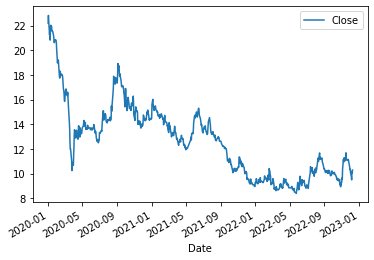

In [121]:
df.plot()

In [122]:
def df_to_ds(df,n=3):
    df = pd.DataFrame({
        'Date': df.index,
        'Close': df['Close'].values
    })
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.pop('index')
    dates = []
    X = []
    Y = []
    for i in range(n,len(df)):
        sub_df = df.loc[i-n:i]
        values = sub_df['Close'].to_numpy()
        x, y = values[:-1], values[-1]
        date = sub_df.iloc[-1]['Date'].date()
        dates.append(date)
        X.append(x)
        Y.append(y)
        try:
            df.iloc[i+1]
        except:
            break

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
    
    ret_df['Target'] = Y

    return ret_df.dropna()

# Start day second time around: '2021-03-25'
windowed_df = df_to_ds(df)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2020-01-06,22.19,22.82,22.35,21.24
1,2020-01-07,22.82,22.35,21.24,21.72
2,2020-01-08,22.35,21.24,21.72,20.82
3,2020-01-09,21.24,21.72,20.82,21.83
4,2020-01-10,21.72,20.82,21.83,22.02
...,...,...,...,...,...
723,2022-12-05,10.34,10.35,10.10,9.77
724,2022-12-06,10.35,10.10,9.77,9.50
725,2022-12-07,10.10,9.77,9.50,10.19
726,2022-12-08,9.77,9.50,10.19,10.03


In [123]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((728,), (728, 3, 1), (728,))

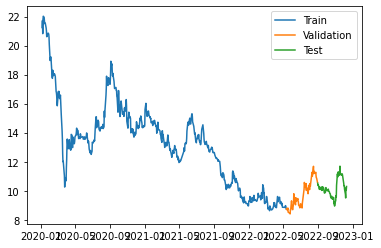

In [124]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [125]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


In [126]:
WINDOW_SIZE = 3
HORIZON = 1
N_NEURONS = 512
N_LAYERS = 4
N_STACK = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [127]:
initial_block = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name="InitialBlock"
)

In [128]:
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")
backcast, forecast = initial_block(stack_input)
residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00") 
for i, _ in enumerate(range(N_STACK-1)):
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")
model.compile(
    loss = tf.keras.losses.mse,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['mean_squared_error']
)

In [129]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
19/19 [==============================] - 19s 448ms/step - loss: 1614.6442 - mean_squared_error: 1614.6442 - val_loss: 0.5611 - val_mean_squared_error: 0.5611
Epoch 2/100
19/19 [==============================] - 6s 327ms/step - loss: 0.5637 - mean_squared_error: 0.5637 - val_loss: 0.2402 - val_mean_squared_error: 0.2402
Epoch 3/100
19/19 [==============================] - 7s 377ms/step - loss: 0.5081 - mean_squared_error: 0.5081 - val_loss: 0.2489 - val_mean_squared_error: 0.2489
Epoch 4/100
19/19 [==============================] - 6s 324ms/step - loss: 0.3457 - mean_squared_error: 0.3457 - val_loss: 0.2360 - val_mean_squared_error: 0.2360
Epoch 5/100
19/19 [==============================] - 6s 309ms/step - loss: 0.3255 - mean_squared_error: 0.3255 - val_loss: 0.3530 - val_mean_squared_error: 0.3530
Epoch 6/100
19/19 [==============================] - 6s 336ms/step - loss: 0.3568 - mean_squared_error: 0.3568 - val_loss: 0.1899 - val_mean_squared_error: 0.1899
Epoch 7/100
19/

In [130]:
np.mean(history.history.get('mean_squared_error'))

16.314534183591604

19/19 [==============================] - 4s 107ms/step


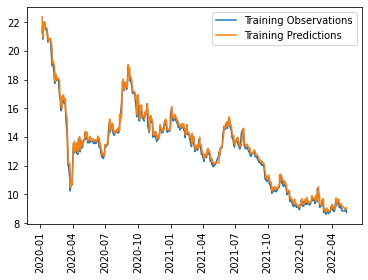

In [131]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, y_train)
plt.plot(dates_train, train_predictions)
plt.xticks(rotation=90)
plt.legend(['Training Observations', 'Training Predictions'])

3/3 [==============================] - 0s 91ms/step


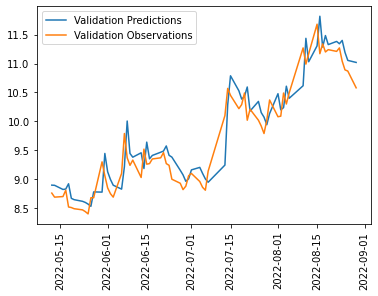

In [132]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 113ms/step


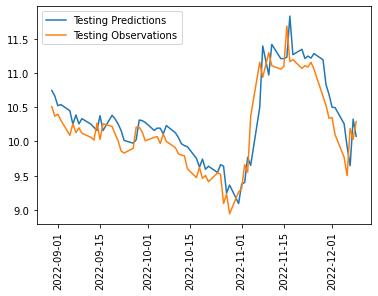

In [133]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

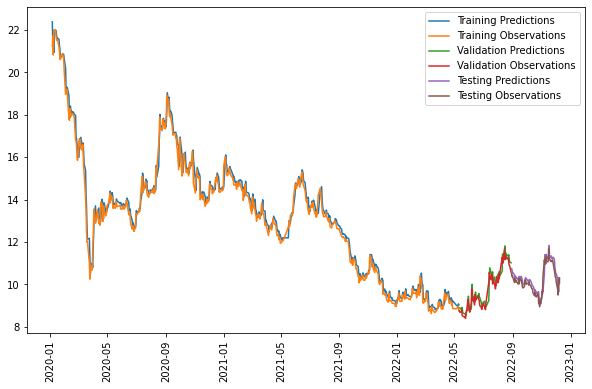

In [134]:
plt.figure(figsize=(10,6))  
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])